
# 1. Setup and Imports
## Import necessary libraries and configure the environment

In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import random
import string
from typing import List, Tuple, Dict
import pandas as pd
from datetime import datetime
import warnings
import logging
import math
# Import qiskit libraries for quantum circuit creation and simulation
from qiskit.circuit.library import MCXGate, HGate, XGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import MCMT

In [11]:
# Suppress specific NumPy warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in det')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='divide by zero encountered in det')

# Test parameters
wordlist_sizes = [1000, 5000, 10000, 20000, 40000, 80000, 160000, 320000]
num_trials = 10  # Number of trials for each wordlist size

# Set up logging
log_filename = f'quantum_search_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)
# Set console handler to only show WARNING and above
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler) and not isinstance(handler, logging.FileHandler):
        handler.setLevel(logging.WARNING)

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Configure matplotlib for better visualization
try:
    plt.style.use('seaborn-v0_8')
except Exception:
    pass

# 2. Helper Functions
## Functions for generating wordlists and implementing classical search

In [12]:
def generate_wordlist(size: int) -> List[str]:
    """Generate a list of random words."""
    return [''.join(random.choices(string.ascii_lowercase, k=8)) for _ in range(size)]

def generate_wordlist_with_target(size: int, target_position: str = 'random') -> Tuple[List[str], int]:
    """Generate a wordlist with a target word at a specified position."""
    wordlist = generate_wordlist(size)
    
    if target_position == 'random':
        target_idx = random.randint(0, size-1)
    elif target_position == 'start':
        target_idx = 0
    elif target_position == 'middle':
        target_idx = size // 2
    elif target_position == 'end':
        target_idx = size - 1
    else:
        raise ValueError(f"Invalid target position: {target_position}")
        
    return wordlist, target_idx

def classical_search(wordlist: List[str], target: str) -> Tuple[float, int]:
    """Perform classical linear search on the wordlist with high-resolution timing."""
    start_time = time.perf_counter()
    iterations = 0
    for word in wordlist:
        iterations += 1
        if word == target:
            break
    end_time = time.perf_counter()
    return end_time - start_time, iterations

# 3. Quantum Implementation
## Implementation of Grover's algorithm for quantum search

In [13]:
def create_oracle(wordlist_size: int, target_index: int) -> QuantumCircuit:
    n_qubits = int(math.ceil(math.log2(wordlist_size)))
    oracle = QuantumCircuit(n_qubits)
    
    # Use MCXGate without mode argument for compatibility
    mcx = MCXGate(n_qubits-1)
    
    # Apply X gates only where needed
    binary = format(target_index, f'0{n_qubits}b')
    for i, bit in enumerate(binary):
        if bit == '0':
            oracle.x(i)
    
    oracle.h(n_qubits-1)
    oracle.append(mcx, list(range(n_qubits)))
    oracle.h(n_qubits-1)
    
    # Reverse X gates
    for i, bit in enumerate(binary):
        if bit == '0':
            oracle.x(i)
            
    return oracle

def create_grover_circuit(wordlist_size: int, target_index: int, num_iterations: int = None) -> QuantumCircuit:
    n_qubits = int(math.ceil(math.log2(wordlist_size)))
    if num_iterations is None:
        num_iterations = int(np.pi/4 * np.sqrt(wordlist_size))
    
    circuit = QuantumCircuit(n_qubits, n_qubits)
    
    # Initial Hadamard layer
    circuit.h(range(n_qubits))
    
    # Create oracle once
    oracle = create_oracle(wordlist_size, target_index)
    
    # Use MCXGate without mode argument for compatibility
    mcx = MCXGate(n_qubits-1)
    
    # Grover iterations
    for _ in range(num_iterations):
        # Apply oracle
        circuit.append(oracle, range(n_qubits))
        
        # Diffusion operator
        circuit.h(range(n_qubits))
        circuit.x(range(n_qubits))
        circuit.h(n_qubits-1)
        circuit.append(mcx, list(range(n_qubits)))
        circuit.h(n_qubits-1)
        circuit.x(range(n_qubits))
        circuit.h(range(n_qubits))
    
    circuit.measure(range(n_qubits), range(n_qubits))
    return circuit

def quantum_search(wordlist_size: int, target_index: int, backend, transpiled_qc=None) -> Tuple[int, float, float, float]:
    n = wordlist_size
    if n == 0:
        return 0, 0.0, 0.0, 0.0
    
    iterations = int(np.pi/4 * np.sqrt(n))
    
    # Use pre-transpiled circuit if provided
    if transpiled_qc is not None:
        qc = transpiled_qc
    else:
        qc = create_grover_circuit(wordlist_size, target_index, iterations)
    
    # Simulator path
    start_time = time.perf_counter()
    job = backend.run(qc, shots=100)  # Reduced shots for simulator
    result = job.result()
    execution_time = time.perf_counter() - start_time
    counts = result.get_counts()
    most_common = max(counts.items(), key=lambda x: x[1])[0]
    index = int(most_common, 2)
    return iterations, execution_time, 0.0, execution_time

# 4. Testing and Benchmarking Functions
## Test and compare classical and quantum approaches for Password Bruteforce

In [14]:
def test_classical_brute_force(wordlist_sizes: List[int], num_trials: int = 5) -> Dict:
    """Test classical brute force with different wordlist sizes and target positions."""
    results = {
        'size': [],
        'position': [],
        'total_time': [],
        'iterations': []
    }
    
    for size in wordlist_sizes:
        logger.info(f"Testing classical search with wordlist size {size}")
        wordlist = generate_wordlist(size)
        target = wordlist[-1]  # Always search for the last word
        
        for trial in range(num_trials):
            logger.info(f"Trial {trial + 1}/{num_trials}")
            exec_time, iterations = classical_search(wordlist, target)
            
            results['size'].append(size)
            results['position'].append('end')
            results['total_time'].append(exec_time)
            results['iterations'].append(iterations)
    
    return results

def test_quantum_search(backend):
    """Test quantum search performance for different wordlist sizes."""
    results = []
    
    for size in wordlist_sizes:
        logger.info(f"Testing quantum search with wordlist size {size}")
        wordlist = generate_wordlist(size)
        target = random.choice(wordlist)
        
        quantum_times = []
        quantum_iterations = []
        
        for trial in range(num_trials):
            logger.info(f"Trial {trial + 1}/{num_trials}")
            iterations, execution_time = quantum_search(size, wordlist.index(target), backend)
            quantum_times.append(execution_time)
            quantum_iterations.append(iterations)
        
        avg_time = np.mean(quantum_times)
        avg_iterations = np.mean(quantum_iterations)
        
        results.append({
            'size': size,
            'quantum_time': avg_time,
            'quantum_iterations': avg_iterations
        })
        
        logger.info(f"Average quantum search time: {avg_time:.4f} seconds")
        logger.info(f"Average iterations: {avg_iterations:.2f}")
    
    return pd.DataFrame(results)

# 5. Visualization Functions
## Helper Functions for plotting comparable results

In [15]:
def fit_curves(x: np.ndarray, y: np.ndarray) -> Tuple[callable, np.ndarray]:
    """Fit curves to the timing data."""
    def linear(x, a, b):
        return a * x + b
    
    def quadratic(x, a, b, c):
        return a * x**2 + b * x + c
    
    # Try both linear and quadratic fits
    popt_linear, _ = curve_fit(linear, x, y)
    popt_quad, _ = curve_fit(quadratic, x, y)
    
    # Calculate R-squared for both fits
    y_pred_linear = linear(x, *popt_linear)
    y_pred_quad = quadratic(x, *popt_quad)
    
    r2_linear = 1 - np.sum((y - y_pred_linear)**2) / np.sum((y - np.mean(y))**2)
    r2_quad = 1 - np.sum((y - y_pred_quad)**2) / np.sum((y - np.mean(y))**2)
    
    # Return the better fit
    if r2_quad > r2_linear:
        return quadratic, popt_quad
    return linear, popt_linear

def plot_performance_comparison(results: pd.DataFrame):
    """Plot performance comparison between classical and quantum search."""
    # Create figure with subplots for each position
    positions = results['position'].unique()
    fig, axes = plt.subplots(len(positions), 2, figsize=(15, 5*len(positions)))
    
    for idx, position in enumerate(positions):
        pos_data = results[results['position'] == position]
        
        # Plot 1: Wallclock Execution Time Comparison
        ax1 = axes[idx, 0]
        ax1.plot(pos_data['size'], pos_data['classical_time'], 'b-o', label='Classical')
        ax1.plot(pos_data['size'], pos_data['quantum_time'], 'r-o', label='Quantum')
        ax1.set_xlabel('Wordlist Size')
        ax1.set_ylabel('Execution Time (s)')
        ax1.set_title(f'Wallclock Execution Time Comparison\nTarget Position: {position}')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Algorithmic Complexity Comparison (Iterations)
        ax2 = axes[idx, 1]
        ax2.plot(pos_data['size'], pos_data['classical_iterations'], 'b-o', label='Classical')
        ax2.plot(pos_data['size'], pos_data['quantum_iterations'], 'r-o', label='Quantum')
        ax2.set_xlabel('Wordlist Size')
        ax2.set_ylabel('Number of Iterations')
        ax2.set_title(f'Algorithmic Complexity Comparison\nTarget Position: {position}')
        ax2.legend()
        ax2.grid(True)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 6. Main Execution
## Run the benchmarks and visualize results - bringing everything together

2025-05-26 20:01:05,627 - INFO - Using Aer simulator with statevector method
2025-05-26 20:01:05,646 - INFO - Testing with wordlist size: 1000
2025-05-26 20:01:05,680 - INFO - Testing with target position: start
2025-05-26 20:01:05,709 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:05,711 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:05,715 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:05,717 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/f


Results for wordlist size 1000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 0.007016 seconds
  Average Iterations: 24.00
  Individual Times: ['0.008180', '0.007401', '0.007658', '0.006734', '0.006586', '0.006380', '0.006890', '0.006525', '0.006917', '0.006888']
  Individual Iterations: ['24', '24', '24', '24', '24', '24', '24', '24', '24', '24']
Speedup:
  Time: 0.00x
  Iterations: 0.04x
--------------------------------------------------


2025-05-26 20:01:06,115 - INFO - Testing with target position: end
2025-05-26 20:01:06,126 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,128 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,134 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,135 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,144 - INFO - Pass: ContainsInstruction - 0.00381 (ms)
2025-


Results for wordlist size 1000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000014 seconds
  Average Iterations: 501.00
  Individual Times: ['0.000014', '0.000014', '0.000014', '0.000014', '0.000014', '0.000014', '0.000014', '0.000014', '0.000014', '0.000014']
  Individual Iterations: ['501', '501', '501', '501', '501', '501', '501', '501', '501', '501']
Quantum Search:
  Average Execution Time: 0.007384 seconds
  Average Iterations: 24.00
  Individual Times: ['0.009134', '0.008818', '0.007031', '0.006895', '0.006779', '0.007896', '0.006888', '0.007368', '0.006311', '0.006720']
  Individual Iterations: ['24', '24', '24', '24', '24', '24', '24', '24', '24', '24']
Speedup:
  Time: 0.00x
  Iterations: 20.88x
--------------------------------------------------

Results for wordlist size 1000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000030 seconds
  Average Iterations: 1000.00
  Individual Times: ['0.000033

2025-05-26 20:01:06,318 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,320 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,324 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,329 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:01:06,575 - INFO - Pass: ContainsInstruction - 0.00501 (ms)
2025-05-26 20:01:06,575 - INFO - Pass: UnitarySynthesis - 0.00381 (ms)
2


Results for wordlist size 1000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000005 seconds
  Average Iterations: 190.00
  Individual Times: ['0.000005', '0.000005', '0.000005', '0.000005', '0.000005', '0.000005', '0.000005', '0.000005', '0.000005', '0.000005']
  Individual Iterations: ['190', '190', '190', '190', '190', '190', '190', '190', '190', '190']
Quantum Search:
  Average Execution Time: 0.007671 seconds
  Average Iterations: 24.00
  Individual Times: ['0.008206', '0.007646', '0.007502', '0.007745', '0.007443', '0.007993', '0.007460', '0.007657', '0.007293', '0.007761']
  Individual Iterations: ['24', '24', '24', '24', '24', '24', '24', '24', '24', '24']
Speedup:
  Time: 0.00x
  Iterations: 7.92x
--------------------------------------------------


2025-05-26 20:01:06,975 - INFO - Pass: CommutationAnalysis - 13.36288 (ms)
2025-05-26 20:01:06,978 - INFO - Pass: CommutativeCancellation - 1.65510 (ms)
2025-05-26 20:01:06,980 - INFO - Pass: GatesInBasis - 2.36106 (ms)
2025-05-26 20:01:06,981 - INFO - Pass: Depth - 0.69785 (ms)
2025-05-26 20:01:06,982 - INFO - Pass: Size - 0.25415 (ms)
2025-05-26 20:01:07,010 - INFO - Pass: MinimumPoint - 27.36306 (ms)
2025-05-26 20:01:07,012 - INFO - Pass: Collect2qBlocks - 1.61886 (ms)
2025-05-26 20:01:07,012 - INFO - Pass: ConsolidateBlocks - 0.32997 (ms)
2025-05-26 20:01:07,013 - INFO - Pass: UnitarySynthesis - 0.00477 (ms)
2025-05-26 20:01:07,059 - INFO - Pass: Optimize1qGatesDecomposition - 45.72797 (ms)
2025-05-26 20:01:07,073 - INFO - Pass: CommutationAnalysis - 13.51333 (ms)
2025-05-26 20:01:07,075 - INFO - Pass: CommutativeCancellation - 1.66225 (ms)
2025-05-26 20:01:07,077 - INFO - Pass: GatesInBasis - 2.42710 (ms)
2025-05-26 20:01:07,078 - INFO - Pass: Depth - 0.62490 (ms)
2025-05-26 20:01


Results for wordlist size 5000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 0.044154 seconds
  Average Iterations: 55.00
  Individual Times: ['0.043509', '0.043362', '0.045060', '0.044515', '0.044646', '0.044033', '0.043364', '0.044084', '0.044627', '0.044345']
  Individual Iterations: ['55', '55', '55', '55', '55', '55', '55', '55', '55', '55']
Speedup:
  Time: 0.00x
  Iterations: 0.02x
--------------------------------------------------


2025-05-26 20:01:07,793 - INFO - Pass: Optimize1qGatesDecomposition - 82.93986 (ms)
2025-05-26 20:01:07,807 - INFO - Pass: CommutationAnalysis - 13.87405 (ms)
2025-05-26 20:01:07,810 - INFO - Pass: CommutativeCancellation - 2.53701 (ms)
2025-05-26 20:01:07,813 - INFO - Pass: GatesInBasis - 2.36392 (ms)
2025-05-26 20:01:07,814 - INFO - Pass: Depth - 0.96893 (ms)
2025-05-26 20:01:07,815 - INFO - Pass: Size - 0.28801 (ms)
2025-05-26 20:01:07,840 - INFO - Pass: MinimumPoint - 24.60694 (ms)
2025-05-26 20:01:07,842 - INFO - Pass: Collect2qBlocks - 1.93501 (ms)
2025-05-26 20:01:07,843 - INFO - Pass: ConsolidateBlocks - 0.33498 (ms)
2025-05-26 20:01:07,843 - INFO - Pass: UnitarySynthesis - 0.00286 (ms)
2025-05-26 20:01:07,888 - INFO - Pass: Optimize1qGatesDecomposition - 44.40188 (ms)
2025-05-26 20:01:07,901 - INFO - Pass: CommutationAnalysis - 12.87484 (ms)
2025-05-26 20:01:07,904 - INFO - Pass: CommutativeCancellation - 1.71876 (ms)
2025-05-26 20:01:07,906 - INFO - Pass: GatesInBasis - 2.336


Results for wordlist size 5000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000077 seconds
  Average Iterations: 2501.00
  Individual Times: ['0.000081', '0.000075', '0.000075', '0.000078', '0.000078', '0.000078', '0.000077', '0.000075', '0.000077', '0.000078']
  Individual Iterations: ['2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501']
Quantum Search:
  Average Execution Time: 0.044176 seconds
  Average Iterations: 55.00
  Individual Times: ['0.044491', '0.044495', '0.044968', '0.044241', '0.044409', '0.044040', '0.044079', '0.044180', '0.043065', '0.043790']
  Individual Iterations: ['55', '55', '55', '55', '55', '55', '55', '55', '55', '55']
Speedup:
  Time: 0.00x
  Iterations: 45.47x
--------------------------------------------------


2025-05-26 20:01:08,561 - INFO - Pass: CommutativeCancellation - 2.15912 (ms)
2025-05-26 20:01:08,563 - INFO - Pass: GatesInBasis - 2.39515 (ms)
2025-05-26 20:01:08,564 - INFO - Pass: Depth - 0.71096 (ms)
2025-05-26 20:01:08,565 - INFO - Pass: Size - 0.25296 (ms)
2025-05-26 20:01:08,592 - INFO - Pass: MinimumPoint - 26.46017 (ms)
2025-05-26 20:01:08,594 - INFO - Pass: Collect2qBlocks - 1.64199 (ms)
2025-05-26 20:01:08,594 - INFO - Pass: ConsolidateBlocks - 0.29802 (ms)
2025-05-26 20:01:08,595 - INFO - Pass: UnitarySynthesis - 0.00501 (ms)
2025-05-26 20:01:08,640 - INFO - Pass: Optimize1qGatesDecomposition - 44.77811 (ms)
2025-05-26 20:01:08,653 - INFO - Pass: CommutationAnalysis - 12.95495 (ms)
2025-05-26 20:01:08,655 - INFO - Pass: CommutativeCancellation - 1.72186 (ms)
2025-05-26 20:01:08,658 - INFO - Pass: GatesInBasis - 2.36392 (ms)
2025-05-26 20:01:08,659 - INFO - Pass: Depth - 0.63491 (ms)
2025-05-26 20:01:08,659 - INFO - Pass: Size - 0.24080 (ms)
2025-05-26 20:01:08,659 - INFO -


Results for wordlist size 5000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000159 seconds
  Average Iterations: 5000.00
  Individual Times: ['0.000152', '0.000150', '0.000150', '0.000150', '0.000153', '0.000150', '0.000205', '0.000168', '0.000150', '0.000161']
  Individual Iterations: ['5000', '5000', '5000', '5000', '5000', '5000', '5000', '5000', '5000', '5000']
Quantum Search:
  Average Execution Time: 0.044870 seconds
  Average Iterations: 55.00
  Individual Times: ['0.045748', '0.044127', '0.045321', '0.045171', '0.045474', '0.044837', '0.043756', '0.044786', '0.044848', '0.044627']
  Individual Iterations: ['55', '55', '55', '55', '55', '55', '55', '55', '55', '55']
Speedup:
  Time: 0.00x
  Iterations: 90.91x
--------------------------------------------------


2025-05-26 20:01:09,314 - INFO - Pass: Collect2qBlocks - 3.12591 (ms)
2025-05-26 20:01:09,316 - INFO - Pass: ConsolidateBlocks - 1.14584 (ms)
2025-05-26 20:01:09,316 - INFO - Pass: UnitarySynthesis - 0.00691 (ms)
2025-05-26 20:01:09,408 - INFO - Pass: Optimize1qGatesDecomposition - 91.34579 (ms)
2025-05-26 20:01:09,423 - INFO - Pass: CommutationAnalysis - 14.76884 (ms)
2025-05-26 20:01:09,426 - INFO - Pass: CommutativeCancellation - 1.82986 (ms)
2025-05-26 20:01:09,428 - INFO - Pass: GatesInBasis - 2.33603 (ms)
2025-05-26 20:01:09,429 - INFO - Pass: Depth - 0.62799 (ms)
2025-05-26 20:01:09,430 - INFO - Pass: Size - 0.26298 (ms)
2025-05-26 20:01:09,457 - INFO - Pass: MinimumPoint - 26.67999 (ms)
2025-05-26 20:01:09,459 - INFO - Pass: Collect2qBlocks - 1.80507 (ms)
2025-05-26 20:01:09,460 - INFO - Pass: ConsolidateBlocks - 0.30684 (ms)
2025-05-26 20:01:09,460 - INFO - Pass: UnitarySynthesis - 0.00405 (ms)
2025-05-26 20:01:09,508 - INFO - Pass: Optimize1qGatesDecomposition - 47.25194 (ms)


Results for wordlist size 5000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000016 seconds
  Average Iterations: 533.00
  Individual Times: ['0.000028', '0.000015', '0.000015', '0.000015', '0.000015', '0.000015', '0.000015', '0.000015', '0.000015', '0.000015']
  Individual Iterations: ['533', '533', '533', '533', '533', '533', '533', '533', '533', '533']
Quantum Search:
  Average Execution Time: 0.044247 seconds
  Average Iterations: 55.00
  Individual Times: ['0.046449', '0.044073', '0.044181', '0.043567', '0.045137', '0.044430', '0.044076', '0.043806', '0.043707', '0.043039']
  Individual Iterations: ['55', '55', '55', '55', '55', '55', '55', '55', '55', '55']
Speedup:
  Time: 0.00x
  Iterations: 9.69x
--------------------------------------------------


2025-05-26 20:01:10,192 - INFO - Begin BasisTranslator from source basis {('mcx', 14), ('measure', 1), ('x', 1), ('h', 1)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ecr', 'rzz', 'mcry', 'mcr', 's', 'cy', 'u1', 'quantum_channel', 'cu3', 'delay', 'z', 'kraus', 'u3', 'cp', 'save_statevector_dict', 'p', 'continue_loop', 'reset'}.
2025-05-26 20:01:10,19


Results for wordlist size 10000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000001', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 0.110583 seconds
  Average Iterations: 78.00
  Individual Times: ['0.112750', '0.114516', '0.108884', '0.108258', '0.109691', '0.111650', '0.113460', '0.108883', '0.108004', '0.109738']
  Individual Iterations: ['78', '78', '78', '78', '78', '78', '78', '78', '78', '78']
Speedup:
  Time: 0.00x
  Iterations: 0.01x
--------------------------------------------------


2025-05-26 20:01:12,006 - INFO - Pass: Optimize1qGatesDecomposition - 132.78604 (ms)
2025-05-26 20:01:12,028 - INFO - Pass: CommutationAnalysis - 22.09115 (ms)
2025-05-26 20:01:12,031 - INFO - Pass: CommutativeCancellation - 2.52891 (ms)
2025-05-26 20:01:12,036 - INFO - Pass: GatesInBasis - 4.44388 (ms)
2025-05-26 20:01:12,037 - INFO - Pass: Depth - 0.96703 (ms)
2025-05-26 20:01:12,038 - INFO - Pass: Size - 0.34618 (ms)
2025-05-26 20:01:12,152 - INFO - Pass: MinimumPoint - 114.07900 (ms)
2025-05-26 20:01:12,155 - INFO - Pass: Collect2qBlocks - 2.47288 (ms)
2025-05-26 20:01:12,156 - INFO - Pass: ConsolidateBlocks - 0.40007 (ms)
2025-05-26 20:01:12,156 - INFO - Pass: UnitarySynthesis - 0.00501 (ms)
2025-05-26 20:01:12,225 - INFO - Pass: Optimize1qGatesDecomposition - 68.16792 (ms)
2025-05-26 20:01:12,246 - INFO - Pass: CommutationAnalysis - 20.60819 (ms)
2025-05-26 20:01:12,249 - INFO - Pass: CommutativeCancellation - 2.91491 (ms)
2025-05-26 20:01:12,253 - INFO - Pass: GatesInBasis - 3.8


Results for wordlist size 10000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000171 seconds
  Average Iterations: 5001.00
  Individual Times: ['0.000188', '0.000243', '0.000163', '0.000162', '0.000157', '0.000154', '0.000151', '0.000153', '0.000187', '0.000156']
  Individual Iterations: ['5001', '5001', '5001', '5001', '5001', '5001', '5001', '5001', '5001', '5001']
Quantum Search:
  Average Execution Time: 0.109901 seconds
  Average Iterations: 78.00
  Individual Times: ['0.109781', '0.109161', '0.109172', '0.109179', '0.109517', '0.108850', '0.111151', '0.111002', '0.111768', '0.109426']
  Individual Iterations: ['78', '78', '78', '78', '78', '78', '78', '78', '78', '78']
Speedup:
  Time: 0.00x
  Iterations: 64.12x
--------------------------------------------------


2025-05-26 20:01:13,674 - INFO - Pass: CommutationAnalysis - 21.39497 (ms)
2025-05-26 20:01:13,677 - INFO - Pass: CommutativeCancellation - 2.57707 (ms)
2025-05-26 20:01:13,681 - INFO - Pass: GatesInBasis - 3.56627 (ms)
2025-05-26 20:01:13,684 - INFO - Pass: Depth - 1.39403 (ms)
2025-05-26 20:01:13,685 - INFO - Pass: Size - 0.48709 (ms)
2025-05-26 20:01:13,802 - INFO - Pass: MinimumPoint - 117.14792 (ms)
2025-05-26 20:01:13,805 - INFO - Pass: Collect2qBlocks - 2.70295 (ms)
2025-05-26 20:01:13,806 - INFO - Pass: ConsolidateBlocks - 0.49424 (ms)
2025-05-26 20:01:13,807 - INFO - Pass: UnitarySynthesis - 0.00525 (ms)
2025-05-26 20:01:13,876 - INFO - Pass: Optimize1qGatesDecomposition - 68.61806 (ms)
2025-05-26 20:01:13,896 - INFO - Pass: CommutationAnalysis - 20.38217 (ms)
2025-05-26 20:01:13,900 - INFO - Pass: CommutativeCancellation - 3.01409 (ms)
2025-05-26 20:01:13,904 - INFO - Pass: GatesInBasis - 3.78394 (ms)
2025-05-26 20:01:13,906 - INFO - Pass: Depth - 0.92292 (ms)
2025-05-26 20:0


Results for wordlist size 10000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000308 seconds
  Average Iterations: 10000.00
  Individual Times: ['0.000321', '0.000319', '0.000303', '0.000302', '0.000303', '0.000302', '0.000303', '0.000303', '0.000325', '0.000303']
  Individual Iterations: ['10000', '10000', '10000', '10000', '10000', '10000', '10000', '10000', '10000', '10000']
Quantum Search:
  Average Execution Time: 0.108907 seconds
  Average Iterations: 78.00
  Individual Times: ['0.108847', '0.109795', '0.108049', '0.107755', '0.109236', '0.107985', '0.109430', '0.109996', '0.108797', '0.109183']
  Individual Iterations: ['78', '78', '78', '78', '78', '78', '78', '78', '78', '78']
Speedup:
  Time: 0.00x
  Iterations: 128.21x
--------------------------------------------------


2025-05-26 20:01:15,301 - INFO - Pass: Optimize1qGatesDecomposition - 130.64694 (ms)
2025-05-26 20:01:15,324 - INFO - Pass: CommutationAnalysis - 23.18096 (ms)
2025-05-26 20:01:15,327 - INFO - Pass: CommutativeCancellation - 2.58875 (ms)
2025-05-26 20:01:15,332 - INFO - Pass: GatesInBasis - 3.69191 (ms)
2025-05-26 20:01:15,334 - INFO - Pass: Depth - 1.33467 (ms)
2025-05-26 20:01:15,334 - INFO - Pass: Size - 0.45013 (ms)
2025-05-26 20:01:15,373 - INFO - Pass: MinimumPoint - 37.91094 (ms)
2025-05-26 20:01:15,376 - INFO - Pass: Collect2qBlocks - 2.65098 (ms)
2025-05-26 20:01:15,377 - INFO - Pass: ConsolidateBlocks - 0.40913 (ms)
2025-05-26 20:01:15,377 - INFO - Pass: UnitarySynthesis - 0.00381 (ms)
2025-05-26 20:01:15,446 - INFO - Pass: Optimize1qGatesDecomposition - 68.71295 (ms)
2025-05-26 20:01:15,467 - INFO - Pass: CommutationAnalysis - 20.91694 (ms)
2025-05-26 20:01:15,470 - INFO - Pass: CommutativeCancellation - 2.48075 (ms)
2025-05-26 20:01:15,474 - INFO - Pass: GatesInBasis - 3.64


Results for wordlist size 10000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000044 seconds
  Average Iterations: 1461.00
  Individual Times: ['0.000046', '0.000043', '0.000043', '0.000043', '0.000043', '0.000043', '0.000043', '0.000043', '0.000043', '0.000043']
  Individual Iterations: ['1461', '1461', '1461', '1461', '1461', '1461', '1461', '1461', '1461', '1461']
Quantum Search:
  Average Execution Time: 0.109433 seconds
  Average Iterations: 78.00
  Individual Times: ['0.109393', '0.109099', '0.107745', '0.108172', '0.108386', '0.109289', '0.109611', '0.111875', '0.110859', '0.109902']
  Individual Iterations: ['78', '78', '78', '78', '78', '78', '78', '78', '78', '78']
Speedup:
  Time: 0.00x
  Iterations: 18.73x
--------------------------------------------------


2025-05-26 20:01:16,798 - INFO - Begin BasisTranslator from source basis {('mcx', 15)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ecr', 'rzz', 'mcry', 'mcr', 's', 'cy', 'u1', 'quantum_channel', 'cu3', 'delay', 'z', 'kraus', 'u3', 'cp', 'save_statevector_dict', 'p', 'continue_loop', 'reset'}.
2025-05-26 20:01:16,799 - INFO - Basis translation path se


Results for wordlist size 20000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 0.254207 seconds
  Average Iterations: 111.00
  Individual Times: ['0.250736', '0.256660', '0.252269', '0.264741', '0.248165', '0.245476', '0.269375', '0.256970', '0.252614', '0.245064']
  Individual Iterations: ['111', '111', '111', '111', '111', '111', '111', '111', '111', '111']
Speedup:
  Time: 0.00x
  Iterations: 0.01x
--------------------------------------------------


2025-05-26 20:01:20,324 - INFO - Pass: InverseCancellation - 104.34198 (ms)
2025-05-26 20:01:20,324 - INFO - Pass: UnitarySynthesis - 0.00286 (ms)
2025-05-26 20:01:20,351 - INFO - Pass: HighLevelSynthesis - 25.98095 (ms)
2025-05-26 20:01:20,362 - INFO - Begin BasisTranslator from source basis {('measure', 1), ('mcx', 15), ('x', 1), ('h', 1)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', '


Results for wordlist size 20000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000324 seconds
  Average Iterations: 10001.00
  Individual Times: ['0.000376', '0.000318', '0.000317', '0.000318', '0.000319', '0.000319', '0.000317', '0.000317', '0.000317', '0.000319']
  Individual Iterations: ['10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001']
Quantum Search:
  Average Execution Time: 0.245064 seconds
  Average Iterations: 111.00
  Individual Times: ['0.261456', '0.264401', '0.239264', '0.240520', '0.243296', '0.245051', '0.241422', '0.237557', '0.237568', '0.240108']
  Individual Iterations: ['111', '111', '111', '111', '111', '111', '111', '111', '111', '111']
Speedup:
  Time: 0.00x
  Iterations: 90.10x
--------------------------------------------------


2025-05-26 20:01:23,524 - INFO - Begin BasisTranslator from source basis {('mcx', 15)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ecr', 'rzz', 'mcry', 'mcr', 's', 'cy', 'u1', 'quantum_channel', 'cu3', 'delay', 'z', 'kraus', 'u3', 'cp', 'save_statevector_dict', 'p', 'continue_loop', 'reset'}.
2025-05-26 20:01:23,524 - INFO - Basis translation path se


Results for wordlist size 20000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000672 seconds
  Average Iterations: 20000.00
  Individual Times: ['0.000717', '0.000636', '0.000635', '0.000635', '0.000635', '0.000635', '0.000640', '0.000635', '0.000873', '0.000676']
  Individual Iterations: ['20000', '20000', '20000', '20000', '20000', '20000', '20000', '20000', '20000', '20000']
Quantum Search:
  Average Execution Time: 0.244280 seconds
  Average Iterations: 111.00
  Individual Times: ['0.236170', '0.241465', '0.235848', '0.295118', '0.238115', '0.237663', '0.236490', '0.241719', '0.233448', '0.246762']
  Individual Iterations: ['111', '111', '111', '111', '111', '111', '111', '111', '111', '111']
Speedup:
  Time: 0.00x
  Iterations: 180.18x
--------------------------------------------------


2025-05-26 20:01:26,806 - INFO - Begin BasisTranslator from source basis {('measure', 1), ('mcx', 15), ('x', 1), ('h', 1)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ecr', 'rzz', 'mcry', 'mcr', 's', 'cy', 'u1', 'quantum_channel', 'cu3', 'delay', 'z', 'kraus', 'u3', 'cp', 'save_statevector_dict', 'p', 'continue_loop', 'reset'}.
2025-05-26 20:01:26,80


Results for wordlist size 20000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000137 seconds
  Average Iterations: 4255.00
  Individual Times: ['0.000156', '0.000135', '0.000135', '0.000135', '0.000135', '0.000135', '0.000135', '0.000135', '0.000135', '0.000135']
  Individual Iterations: ['4255', '4255', '4255', '4255', '4255', '4255', '4255', '4255', '4255', '4255']
Quantum Search:
  Average Execution Time: 0.237013 seconds
  Average Iterations: 111.00
  Individual Times: ['0.235478', '0.237152', '0.241584', '0.237546', '0.236875', '0.237697', '0.236504', '0.237208', '0.235655', '0.234427']
  Individual Iterations: ['111', '111', '111', '111', '111', '111', '111', '111', '111', '111']
Speedup:
  Time: 0.00x
  Iterations: 38.33x
--------------------------------------------------


2025-05-26 20:01:29,992 - INFO - Pass: ContainsInstruction - 0.00501 (ms)
2025-05-26 20:01:29,993 - INFO - Pass: UnitarySynthesis - 0.00501 (ms)
2025-05-26 20:01:30,046 - INFO - Pass: HighLevelSynthesis - 52.94609 (ms)
2025-05-26 20:01:30,056 - INFO - Begin BasisTranslator from source basis {('mcx', 16)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ec


Results for wordlist size 40000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 0.582617 seconds
  Average Iterations: 157.00
  Individual Times: ['0.594421', '0.585075', '0.573336', '0.583359', '0.576084', '0.590042', '0.602216', '0.574126', '0.572934', '0.574571']
  Individual Iterations: ['157', '157', '157', '157', '157', '157', '157', '157', '157', '157']
Speedup:
  Time: 0.00x
  Iterations: 0.01x
--------------------------------------------------


2025-05-26 20:01:37,086 - INFO - Pass: ContainsInstruction - 0.00477 (ms)
2025-05-26 20:01:37,087 - INFO - Pass: UnitarySynthesis - 0.00477 (ms)
2025-05-26 20:01:37,132 - INFO - Pass: HighLevelSynthesis - 44.63577 (ms)
2025-05-26 20:01:37,141 - INFO - Begin BasisTranslator from source basis {('mcx', 16)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ec


Results for wordlist size 40000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000917 seconds
  Average Iterations: 20001.00
  Individual Times: ['0.001751', '0.001674', '0.000836', '0.000714', '0.000687', '0.000688', '0.000763', '0.000688', '0.000686', '0.000687']
  Individual Iterations: ['20001', '20001', '20001', '20001', '20001', '20001', '20001', '20001', '20001', '20001']
Quantum Search:
  Average Execution Time: 0.585599 seconds
  Average Iterations: 157.00
  Individual Times: ['0.569594', '0.588767', '0.577988', '0.580409', '0.575766', '0.589578', '0.586611', '0.587871', '0.585500', '0.613903']
  Individual Iterations: ['157', '157', '157', '157', '157', '157', '157', '157', '157', '157']
Speedup:
  Time: 0.00x
  Iterations: 127.39x
--------------------------------------------------


2025-05-26 20:01:44,179 - INFO - Pass: ContainsInstruction - 0.00477 (ms)
2025-05-26 20:01:44,180 - INFO - Pass: UnitarySynthesis - 0.00620 (ms)
2025-05-26 20:01:44,219 - INFO - Pass: HighLevelSynthesis - 38.87010 (ms)
2025-05-26 20:01:44,228 - INFO - Begin BasisTranslator from source basis {('mcx', 16)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ec


Results for wordlist size 40000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.001502 seconds
  Average Iterations: 40000.00
  Individual Times: ['0.001777', '0.001575', '0.001387', '0.001400', '0.001639', '0.001478', '0.001468', '0.001376', '0.001377', '0.001546']
  Individual Iterations: ['40000', '40000', '40000', '40000', '40000', '40000', '40000', '40000', '40000', '40000']
Quantum Search:
  Average Execution Time: 0.590583 seconds
  Average Iterations: 157.00
  Individual Times: ['0.632041', '0.587542', '0.579204', '0.582542', '0.593411', '0.585599', '0.588220', '0.586627', '0.584033', '0.586608']
  Individual Iterations: ['157', '157', '157', '157', '157', '157', '157', '157', '157', '157']
Speedup:
  Time: 0.00x
  Iterations: 254.78x
--------------------------------------------------


2025-05-26 20:01:51,291 - INFO - Pass: ContainsInstruction - 0.00525 (ms)
2025-05-26 20:01:51,291 - INFO - Pass: UnitarySynthesis - 0.00405 (ms)
2025-05-26 20:01:51,332 - INFO - Pass: HighLevelSynthesis - 40.23600 (ms)
2025-05-26 20:01:51,341 - INFO - Begin BasisTranslator from source basis {('mcx', 16)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ec


Results for wordlist size 40000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000368 seconds
  Average Iterations: 9903.00
  Individual Times: ['0.000410', '0.000362', '0.000361', '0.000362', '0.000361', '0.000373', '0.000365', '0.000361', '0.000361', '0.000361']
  Individual Iterations: ['9903', '9903', '9903', '9903', '9903', '9903', '9903', '9903', '9903', '9903']
Quantum Search:
  Average Execution Time: 0.599772 seconds
  Average Iterations: 157.00
  Individual Times: ['0.575412', '0.665323', '0.599673', '0.589998', '0.597993', '0.589057', '0.602123', '0.591409', '0.592235', '0.594496']
  Individual Iterations: ['157', '157', '157', '157', '157', '157', '157', '157', '157', '157']
Speedup:
  Time: 0.00x
  Iterations: 63.08x
--------------------------------------------------


2025-05-26 20:01:58,591 - INFO - Pass: ContainsInstruction - 0.00691 (ms)
2025-05-26 20:01:58,592 - INFO - Pass: UnitarySynthesis - 0.00429 (ms)
2025-05-26 20:01:58,669 - INFO - Pass: HighLevelSynthesis - 76.81775 (ms)
2025-05-26 20:01:58,684 - INFO - Begin BasisTranslator from source basis {('mcx', 17)} to target basis {'rzx', 'unitary', 'if_else', 'u2', 'h', 'mcp', 'save_probabilities', 'barrier', 'mcu', 'mcsx', 'ryy', 'ccx', 'sdg', 'save_density_matrix', 'snapshot', 'x', 'id', 'switch_case', 'sx', 'mcrz', 'csx', 'ry', 'cu1', 'save_statevector', 'while_loop', 'mcu1', 'y', 'mcy', 'pauli', 'set_statevector', 'save_amplitudes', 'measure', 'save_probabilities_dict', 'cz', 'rz', 'rx', 'break_loop', 'save_state', 'diagonal', 'mcu3', 'swap', 'save_amplitudes_sq', 'cu', 'multiplexer', 'tdg', 'mcx', 'mcswap', 'mcz', 'mcu2', 'sxdg', 'u', 't', 'save_expval_var', 'roerror', 'cu2', 'save_expval', 'cswap', 'r', 'qerror_loc', 'mcrx', 'for_loop', 'initialize', 'mcphase', 'rxx', 'mcx_gray', 'cx', 'ec


Results for wordlist size 80000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000001', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 1.643275 seconds
  Average Iterations: 222.00
  Individual Times: ['1.617529', '1.625500', '1.637892', '1.682521', '1.647327', '1.637386', '1.642510', '1.653590', '1.639331', '1.649168']
  Individual Iterations: ['222', '222', '222', '222', '222', '222', '222', '222', '222', '222']
Speedup:
  Time: 0.00x
  Iterations: 0.00x
--------------------------------------------------


2025-05-26 20:02:16,771 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:16,773 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:16,776 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:16,777 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:16,979 - INFO - Pass: ContainsInstruction - 0.00691 (ms)
2025-05-26 20:02:16,979 - INFO - Pass: UnitarySynthesis - 0.00310 (ms)
2


Results for wordlist size 80000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.001618 seconds
  Average Iterations: 40001.00
  Individual Times: ['0.001877', '0.001684', '0.001581', '0.001573', '0.001573', '0.001599', '0.001577', '0.001573', '0.001571', '0.001573']
  Individual Iterations: ['40001', '40001', '40001', '40001', '40001', '40001', '40001', '40001', '40001', '40001']
Quantum Search:
  Average Execution Time: 1.643100 seconds
  Average Iterations: 222.00
  Individual Times: ['1.595777', '1.627970', '1.632657', '1.637305', '1.635014', '1.643306', '1.635950', '1.664729', '1.705833', '1.652460']
  Individual Iterations: ['222', '222', '222', '222', '222', '222', '222', '222', '222', '222']
Speedup:
  Time: 0.00x
  Iterations: 180.18x
--------------------------------------------------


2025-05-26 20:02:35,144 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:35,146 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:35,149 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:35,152 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:35,244 - INFO - Pass: ContainsInstruction - 0.00691 (ms)
2025-05-26 20:02:35,245 - INFO - Pass: UnitarySynthesis - 0.00525 (ms)
2


Results for wordlist size 80000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.003505 seconds
  Average Iterations: 80000.00
  Individual Times: ['0.003633', '0.003282', '0.003318', '0.003225', '0.003447', '0.003559', '0.003541', '0.003625', '0.003653', '0.003771']
  Individual Iterations: ['80000', '80000', '80000', '80000', '80000', '80000', '80000', '80000', '80000', '80000']
Quantum Search:
  Average Execution Time: 1.673636 seconds
  Average Iterations: 222.00
  Individual Times: ['1.625293', '1.662067', '1.667430', '1.666010', '1.667141', '1.687178', '1.689109', '1.680701', '1.690969', '1.700459']
  Individual Iterations: ['222', '222', '222', '222', '222', '222', '222', '222', '222', '222']
Speedup:
  Time: 0.00x
  Iterations: 360.36x
--------------------------------------------------


2025-05-26 20:02:53,715 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:53,717 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:53,722 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:53,725 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:02:53,894 - INFO - Pass: ContainsInstruction - 0.00620 (ms)
2025-05-26 20:02:53,895 - INFO - Pass: UnitarySynthesis - 0.00381 (ms)
2


Results for wordlist size 80000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.002558 seconds
  Average Iterations: 55343.00
  Individual Times: ['0.002870', '0.002459', '0.003009', '0.002707', '0.002532', '0.002252', '0.002308', '0.002462', '0.002445', '0.002534']
  Individual Iterations: ['55343', '55343', '55343', '55343', '55343', '55343', '55343', '55343', '55343', '55343']
Quantum Search:
  Average Execution Time: 1.685394 seconds
  Average Iterations: 222.00
  Individual Times: ['1.709530', '1.674848', '1.670202', '1.698628', '1.675380', '1.690025', '1.687231', '1.688954', '1.680847', '1.678299']
  Individual Iterations: ['222', '222', '222', '222', '222', '222', '222', '222', '222', '222']
Speedup:
  Time: 0.00x
  Iterations: 249.29x
--------------------------------------------------


2025-05-26 20:03:12,615 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:03:12,616 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:03:12,620 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:03:12,621 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:03:12,841 - INFO - Pass: ContainsInstruction - 0.00811 (ms)
2025-05-26 20:03:12,841 - INFO - Pass: UnitarySynthesis - 0.00405 (ms)
2


Results for wordlist size 160000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 4.525358 seconds
  Average Iterations: 314.00
  Individual Times: ['4.461972', '4.573624', '4.499872', '4.531821', '4.499013', '4.730591', '4.472811', '4.505827', '4.513354', '4.464692']
  Individual Iterations: ['314', '314', '314', '314', '314', '314', '314', '314', '314', '314']
Speedup:
  Time: 0.00x
  Iterations: 0.00x
--------------------------------------------------


2025-05-26 20:04:00,857 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:00,859 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:00,862 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:00,863 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:01,001 - INFO - Pass: ContainsInstruction - 0.00691 (ms)
2025-05-26 20:04:01,001 - INFO - Pass: UnitarySynthesis - 0.00405 (ms)
2


Results for wordlist size 160000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.003200 seconds
  Average Iterations: 80001.00
  Individual Times: ['0.003323', '0.003247', '0.003320', '0.002971', '0.003157', '0.003295', '0.002998', '0.003119', '0.003312', '0.003259']
  Individual Iterations: ['80001', '80001', '80001', '80001', '80001', '80001', '80001', '80001', '80001', '80001']
Quantum Search:
  Average Execution Time: 4.563572 seconds
  Average Iterations: 314.00
  Individual Times: ['4.519204', '4.462950', '4.532567', '4.620725', '4.542395', '4.731606', '4.595800', '4.576869', '4.513135', '4.540471']
  Individual Iterations: ['314', '314', '314', '314', '314', '314', '314', '314', '314', '314']
Speedup:
  Time: 0.00x
  Iterations: 254.78x
--------------------------------------------------


2025-05-26 20:04:49,535 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:49,537 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:49,539 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:49,541 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:04:49,665 - INFO - Pass: ContainsInstruction - 0.00691 (ms)
2025-05-26 20:04:49,665 - INFO - Pass: UnitarySynthesis - 0.00501 (ms)
2


Results for wordlist size 160000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.006788 seconds
  Average Iterations: 160000.00
  Individual Times: ['0.006796', '0.006916', '0.006972', '0.007995', '0.007366', '0.006786', '0.006775', '0.006179', '0.006197', '0.005895']
  Individual Iterations: ['160000', '160000', '160000', '160000', '160000', '160000', '160000', '160000', '160000', '160000']
Quantum Search:
  Average Execution Time: 4.519123 seconds
  Average Iterations: 314.00
  Individual Times: ['4.474602', '4.519383', '4.600748', '4.507907', '4.477762', '4.508224', '4.506858', '4.482696', '4.582200', '4.530847']
  Individual Iterations: ['314', '314', '314', '314', '314', '314', '314', '314', '314', '314']
Speedup:
  Time: 0.00x
  Iterations: 509.55x
--------------------------------------------------


2025-05-26 20:05:37,520 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:05:37,521 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:05:37,524 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:05:37,526 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:05:37,813 - INFO - Pass: ContainsInstruction - 0.00715 (ms)
2025-05-26 20:05:37,813 - INFO - Pass: UnitarySynthesis - 0.00477 (ms)
2


Results for wordlist size 160000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.002633 seconds
  Average Iterations: 60782.00
  Individual Times: ['0.003015', '0.002774', '0.002688', '0.002724', '0.002620', '0.002483', '0.002527', '0.002447', '0.002614', '0.002442']
  Individual Iterations: ['60782', '60782', '60782', '60782', '60782', '60782', '60782', '60782', '60782', '60782']
Quantum Search:
  Average Execution Time: 4.571143 seconds
  Average Iterations: 314.00
  Individual Times: ['4.434817', '4.507715', '4.494962', '4.723107', '4.559066', '4.816520', '4.575829', '4.492105', '4.512020', '4.595290']
  Individual Iterations: ['314', '314', '314', '314', '314', '314', '314', '314', '314', '314']
Speedup:
  Time: 0.00x
  Iterations: 193.57x
--------------------------------------------------


2025-05-26 20:06:26,433 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:06:26,435 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:06:26,437 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:06:26,439 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:06:26,796 - INFO - Pass: ContainsInstruction - 0.00691 (ms)
2025-05-26 20:06:26,797 - INFO - Pass: UnitarySynthesis - 0.00405 (ms)
2


Results for wordlist size 320000, position start (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.000000 seconds
  Average Iterations: 1.00
  Individual Times: ['0.000001', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
  Individual Iterations: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Quantum Search:
  Average Execution Time: 13.373827 seconds
  Average Iterations: 444.00
  Individual Times: ['13.056970', '13.323275', '13.492191', '13.311107', '13.290800', '13.420674', '13.408299', '13.472489', '13.456676', '13.505790']
  Individual Iterations: ['444', '444', '444', '444', '444', '444', '444', '444', '444', '444']
Speedup:
  Time: 0.00x
  Iterations: 0.00x
--------------------------------------------------


2025-05-26 20:08:44,896 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:08:44,897 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:08:44,900 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:08:44,901 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:08:45,207 - INFO - Pass: ContainsInstruction - 0.00715 (ms)
2025-05-26 20:08:45,208 - INFO - Pass: UnitarySynthesis - 0.00525 (ms)
2


Results for wordlist size 320000, position middle (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.005809 seconds
  Average Iterations: 160001.00
  Individual Times: ['0.005715', '0.006148', '0.005392', '0.005893', '0.005741', '0.005319', '0.005592', '0.005651', '0.005733', '0.006903']
  Individual Iterations: ['160001', '160001', '160001', '160001', '160001', '160001', '160001', '160001', '160001', '160001']
Quantum Search:
  Average Execution Time: 15.278254 seconds
  Average Iterations: 444.00
  Individual Times: ['13.208714', '13.449372', '13.519385', '15.455607', '15.166281', '15.727404', '15.675266', '15.968594', '17.560251', '17.051662']
  Individual Iterations: ['444', '444', '444', '444', '444', '444', '444', '444', '444', '444']
Speedup:
  Time: 0.00x
  Iterations: 360.36x
--------------------------------------------------


2025-05-26 20:11:22,409 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:11:22,411 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:11:22,413 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:11:22,415 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:11:22,729 - INFO - Pass: ContainsInstruction - 0.00811 (ms)
2025-05-26 20:11:22,729 - INFO - Pass: UnitarySynthesis - 0.00405 (ms)
2


Results for wordlist size 320000, position end (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.012002 seconds
  Average Iterations: 320000.00
  Individual Times: ['0.011721', '0.012014', '0.011517', '0.012245', '0.011514', '0.012600', '0.013260', '0.011073', '0.011900', '0.012178']
  Individual Iterations: ['320000', '320000', '320000', '320000', '320000', '320000', '320000', '320000', '320000', '320000']
Quantum Search:
  Average Execution Time: 13.800708 seconds
  Average Iterations: 444.00
  Individual Times: ['13.223164', '13.677471', '14.655839', '13.645159', '13.850969', '13.702035', '13.634660', '14.316828', '13.634442', '13.666510']
  Individual Iterations: ['444', '444', '444', '444', '444', '444', '444', '444', '444', '444']
Speedup:
  Time: 0.00x
  Iterations: 720.72x
--------------------------------------------------


2025-05-26 20:13:44,969 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:13:44,970 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:13:44,973 - ERROR - Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:13:44,974 - ERROR - Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/sid62/quantum-notebooks/fresh-quantum-env/lib/python3.10/site-packages/qiskit/__init__.py)
2025-05-26 20:13:45,387 - INFO - Pass: ContainsInstruction - 0.00596 (ms)
2025-05-26 20:13:45,387 - INFO - Pass: UnitarySynthesis - 0.00429 (ms)
2


Results for wordlist size 320000, position random (Average of 10 trials):
Classical Search:
  Average Execution Time: 0.011152 seconds
  Average Iterations: 313253.00
  Individual Times: ['0.011695', '0.011118', '0.010781', '0.011155', '0.011305', '0.010832', '0.011102', '0.012018', '0.011125', '0.010392']
  Individual Iterations: ['313253', '313253', '313253', '313253', '313253', '313253', '313253', '313253', '313253', '313253']
Quantum Search:
  Average Execution Time: 15.647271 seconds
  Average Iterations: 444.00
  Individual Times: ['13.875532', '13.692165', '18.118127', '19.613822', '17.661695', '17.766402', '17.173438', '12.577964', '12.946253', '13.047311']
  Individual Iterations: ['444', '444', '444', '444', '444', '444', '444', '444', '444', '444']
Speedup:
  Time: 0.00x
  Iterations: 705.52x
--------------------------------------------------


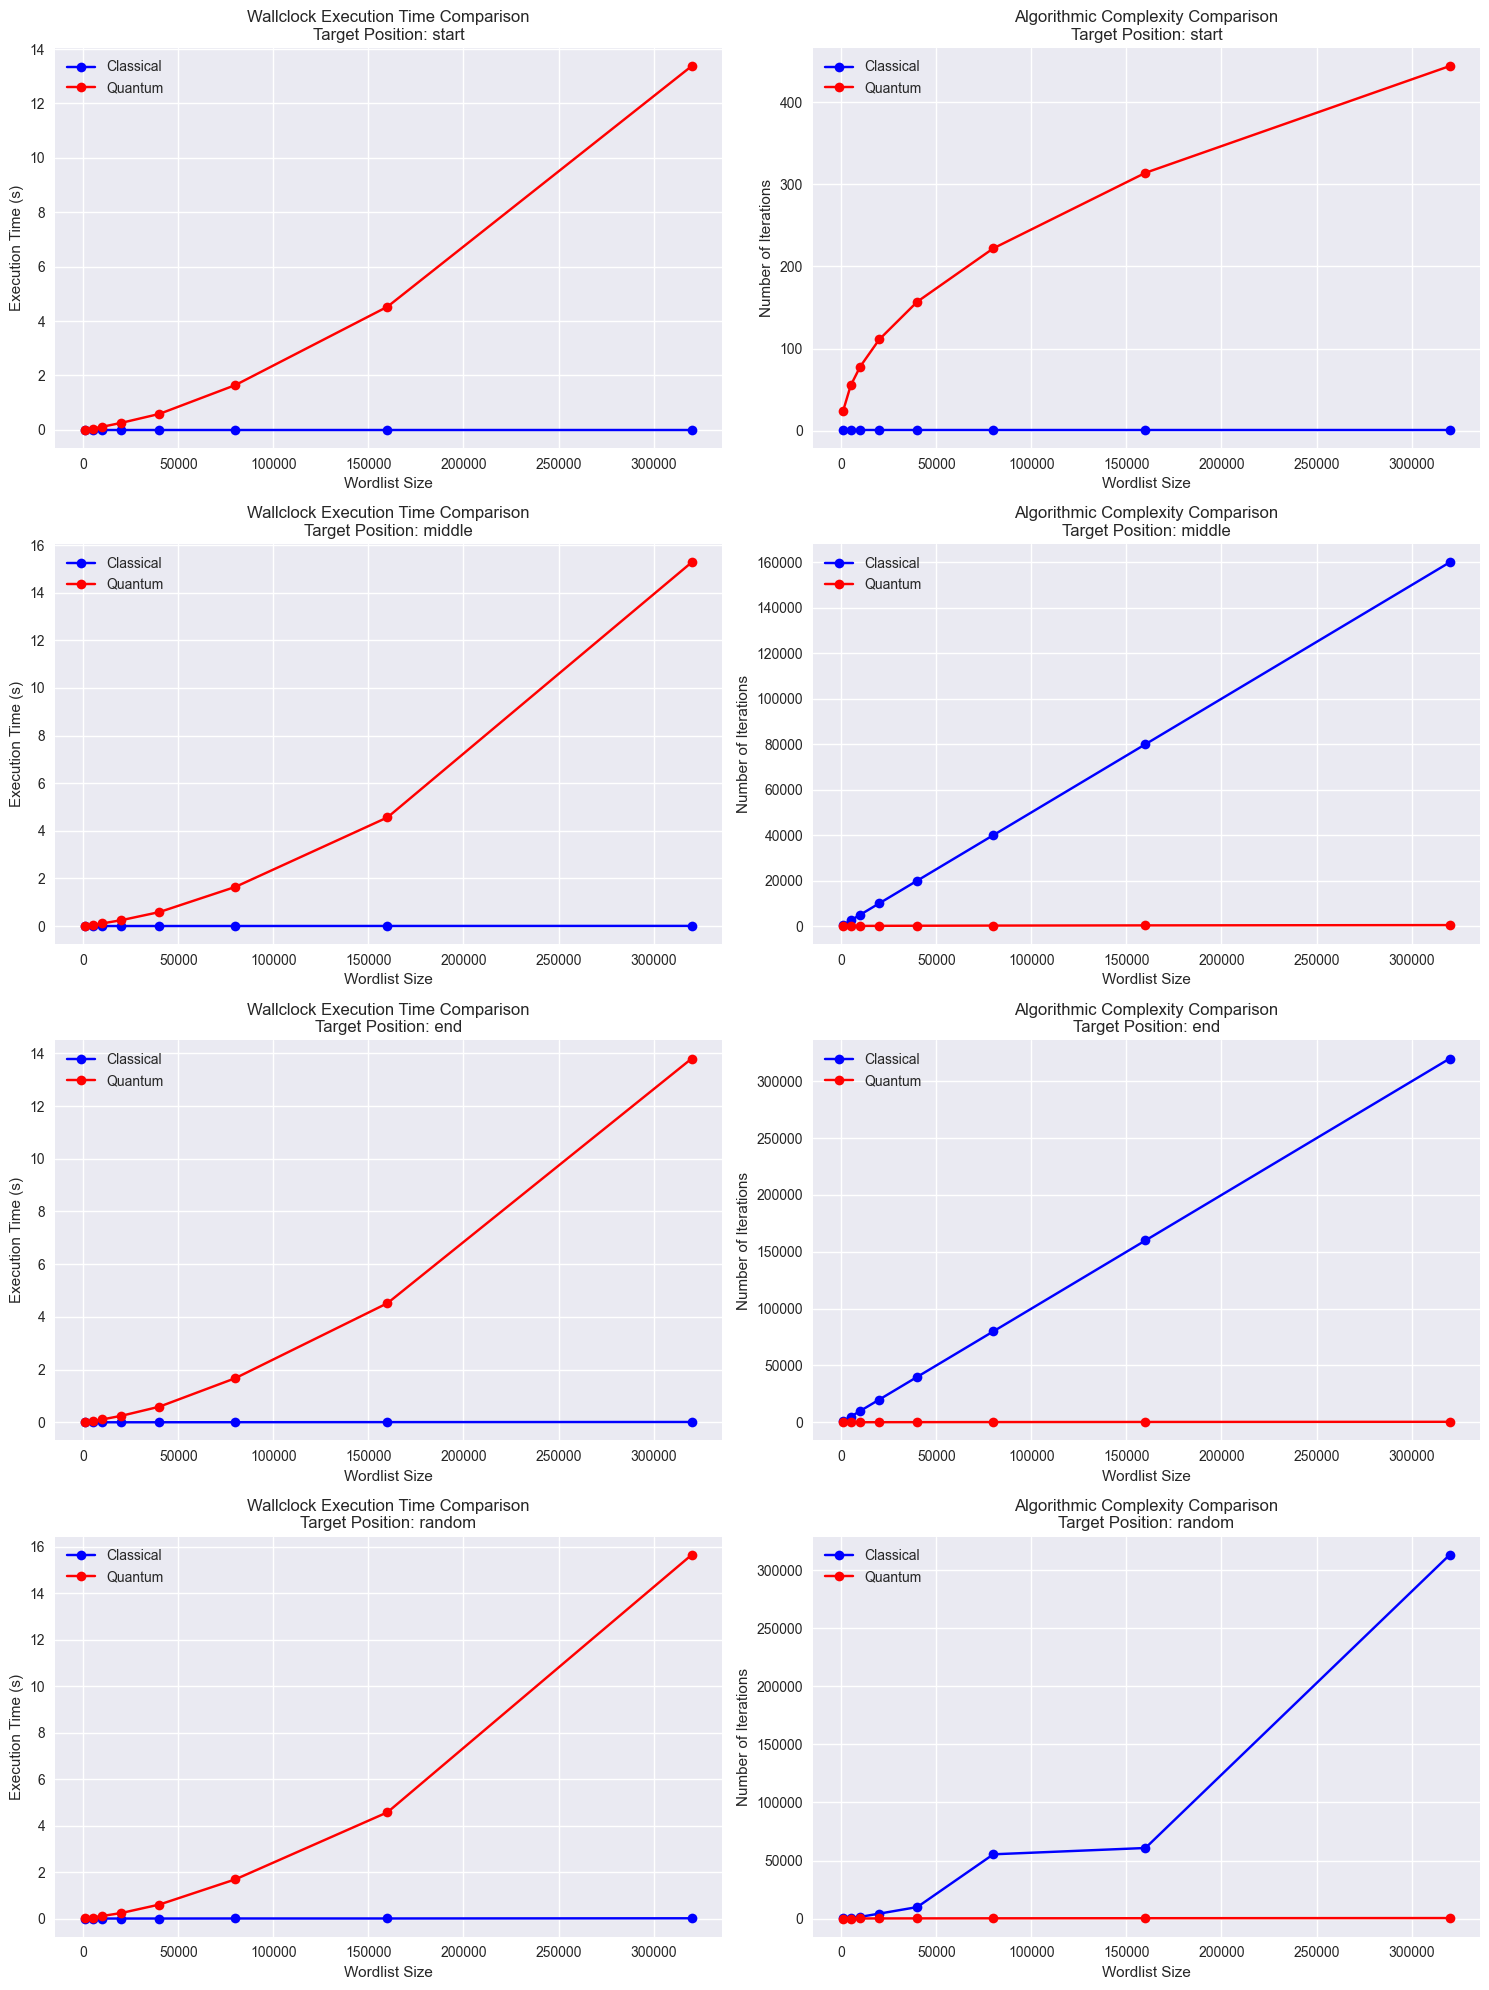

2025-05-26 20:17:00,520 - INFO - Plot saved as performance_comparison.png
2025-05-26 20:17:00,526 - INFO - Comparison completed successfully


In [16]:
def run_comparison(backend):
    results = []
    target_positions = ['start', 'middle', 'end', 'random']
    
    for size in wordlist_sizes:
        logger.info(f"Testing with wordlist size: {size}")
        
        for position in target_positions:
            logger.info(f"Testing with target position: {position}")
            # Generate test data and target index
            wordlist, target_idx = generate_wordlist_with_target(size, position)
            target = wordlist[target_idx]
            
            # Classical search (timing only the search)
            classical_times = []
            classical_iterations = []
            for _ in range(num_trials):
                exec_time, iterations = classical_search(wordlist, target)
                classical_times.append(exec_time)
                classical_iterations.append(iterations)
                
            # Quantum: transpile only for simulator with optimized settings
            qc = create_grover_circuit(size, target_idx)
            transpiled_qc = transpile(qc, backend, 
                                    optimization_level=3,
                                    layout_method='trivial',
                                    routing_method='basic')
            
            quantum_times = []
            quantum_iterations = []
            for _ in range(num_trials):
                iterations, exec_time, _, _ = quantum_search(size, target_idx, backend, transpiled_qc)
                quantum_times.append(exec_time)
                quantum_iterations.append(iterations)
                
            avg_classical_time = np.mean(classical_times)
            avg_quantum_time = np.mean(quantum_times)
            avg_classical_iterations = np.mean(classical_iterations)
            avg_quantum_iterations = np.mean(quantum_iterations)
            
            results.append({
                'size': size,
                'position': position,
                'classical_time': avg_classical_time,
                'quantum_time': avg_quantum_time,
                'classical_iterations': avg_classical_iterations,
                'quantum_iterations': avg_quantum_iterations,
                'speedup_time': avg_classical_time / avg_quantum_time if avg_quantum_time > 0 else float('inf'),
                'speedup_iterations': avg_classical_iterations / avg_quantum_iterations if avg_quantum_iterations > 0 else float('inf')
            })
            
            print(f"\nResults for wordlist size {size}, position {position} (Average of {num_trials} trials):")
            print(f"Classical Search:")
            print(f"  Average Execution Time: {avg_classical_time:.6f} seconds")
            print(f"  Average Iterations: {avg_classical_iterations:.2f}")
            print(f"  Individual Times: {[f'{t:.6f}' for t in classical_times]}")
            print(f"  Individual Iterations: {[f'{i:.0f}' for i in classical_iterations]}")
            print(f"Quantum Search:")
            print(f"  Average Execution Time: {avg_quantum_time:.6f} seconds")
            print(f"  Average Iterations: {avg_quantum_iterations:.2f}")
            print(f"  Individual Times: {[f'{t:.6f}' for t in quantum_times]}")
            print(f"  Individual Iterations: {[f'{i:.0f}' for i in quantum_iterations]}")
            print(f"Speedup:")
            print(f"  Time: {avg_classical_time/avg_quantum_time:.2f}x")
            print(f"  Iterations: {avg_classical_iterations/avg_quantum_iterations:.2f}x")
            print("-" * 50)
    return pd.DataFrame(results)

def main():
    # Initialize backend
    backend = Aer.get_backend('aer_simulator')
    # Set backend options for correct simulation
    backend.set_options(method='statevector', device='CPU', max_parallel_experiments=1)
    logger.info("Using Aer simulator with statevector method")

    # Run comparison
    results_df = run_comparison(backend)
    
    # Save results
    classical_df = results_df[['size', 'classical_time', 'classical_iterations']]
    quantum_df = results_df[['size', 'quantum_time', 'quantum_iterations']]
    classical_df.to_csv('classical_results.csv', index=False)
    quantum_df.to_csv('quantum_results.csv', index=False)
    logger.info("Classical results saved to classical_results.csv")
    logger.info("Quantum results saved to quantum_results.csv")
    
    # Plot results
    plot_performance_comparison(results_df)
    logger.info("Plot saved as performance_comparison.png")
    
    logger.info("Comparison completed successfully")

if __name__ == "__main__":
    main() 